In [2]:
import numpy as np
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
from tsai.all import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix, roc_auc_score, f1_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from utils import *
from sklearn.neighbors import KernelDensity
import scipy as sp

## Read data

In [30]:

error_not_distracted_list, u_signal_not_distracted_list = process_signals(error_file= r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PSN/e.csv', u_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PSN/u.csv')
error_distracted_list, u_signal_distracted_list         = process_signals(error_file= r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PSDCE/e.csv', u_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PSDCE/u.csv')

error_test, u_signal_test = process_signals(error_file= r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PSDPE/e.csv', u_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PSDPE/u.csv')

person_idx = 1

# combine the entire list in the priors
error_not_distracted = np.concatenate(error_not_distracted_list[person_idx])
u_not_distracted = np.concatenate(u_signal_not_distracted_list[person_idx])

error_distracted = np.concatenate(error_distracted_list[person_idx])
u_distracted = np.concatenate(u_signal_distracted_list[person_idx])

error_test = np.concatenate(error_test[person_idx])
u_signal_test = np.concatenate(u_signal_test[person_idx])


tc_test = np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PSDPE/mdist.csv', delimiter=',')
print(f"{tc_test.shape=}; {error_test.shape=}; {u_signal_test.shape=}")

tc_test.shape=(12000, 40); error_test.shape=(48000,); u_signal_test.shape=(48000,)


## Estimate piors' PDFs and Visualize

In [6]:
def estimate_distribution_single(data, bandwidth=0.1):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(data[:, None])
    return kde

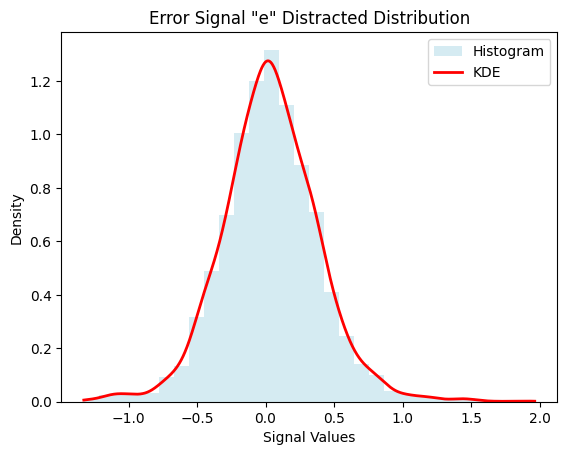

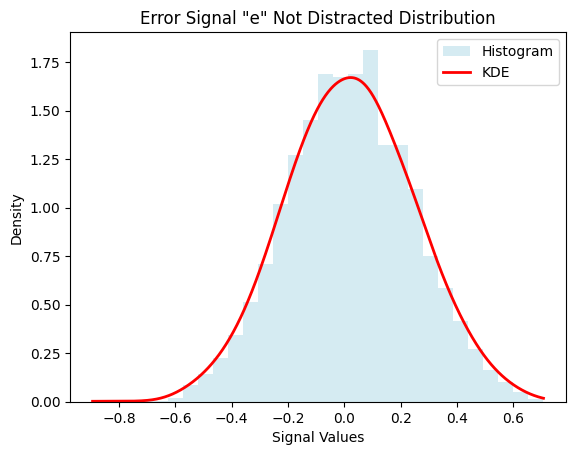

In [7]:
# Function to visualize KDE and histogram for any signal
def plot_kde_histogram(data, title, color='lightblue', kde_color='red', bandwidth=0.2, bins=30):
    """
    Plots a histogram with KDE overlay for the given data.
    
    Parameters:
    data (numpy array): Input signal data to plot.
    title (str): Title of the plot.
    color (str): Color of the histogram.
    kde_color (str): Color of the KDE plot.
    bandwidth (float): Bandwidth for the KDE.
    bins (int): Number of bins in the histogram.
    """
    # Step 1: Plot histogram
    plt.hist(data, bins=bins, density=True, alpha=0.5, color=color, label='Histogram')

    # Step 2: Estimate the KDE
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(data[:, None])

    # Create an array of values where KDE will be evaluated
    x_vals = np.linspace(data.min(), data.max(), 1000)

    # Step 3: Evaluate the KDE to get the probability densities
    log_density = kde.score_samples(x_vals[:, None])  # Returns log of density
    density = np.exp(log_density)  # Convert log density back to normal density

    # Step 4: Plot the KDE on top of the histogram
    plt.plot(x_vals, density, color=kde_color, label='KDE', linewidth=2)

    # Add labels and title
    plt.xlabel('Signal Values')
    plt.ylabel('Density')
    plt.title(title)
    plt.legend()

    # Show the plot
    plt.show()

# Visualize the error_signal
plot_kde_histogram(error_distracted, title='Error Signal "e" Distracted Distribution', bandwidth=0.07)

# Visualize the control input signal (u_signal)
plot_kde_histogram(error_not_distracted, title='Error Signal "e" Not Distracted Distribution', bandwidth=0.07)

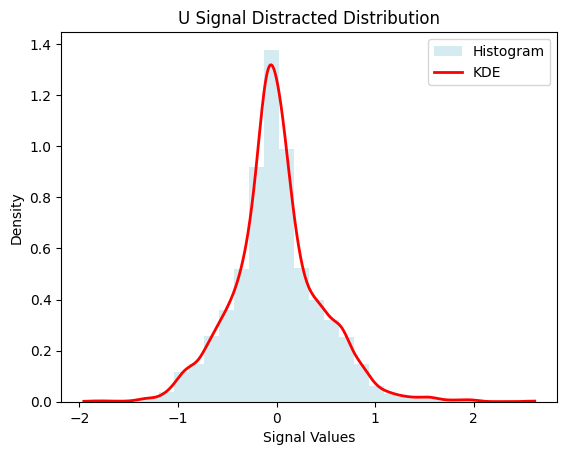

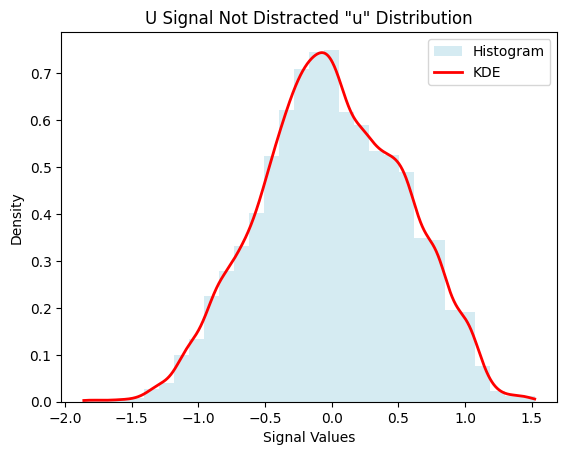

In [8]:
# Visualize the error_signal
plot_kde_histogram(u_distracted, title='U Signal Distracted Distribution', bandwidth=0.07)

# Visualize the control input signal (u_signal)
plot_kde_histogram(u_not_distracted, title='U Signal Not Distracted "u" Distribution', bandwidth=0.07)

## Generate windowed data

In [31]:
def create_windows(data, window_size=100, overlap=0.5):
    """
    Creates windows of the given data with the specified window size and overlap.
    
    Parameters:
    data (numpy array): Input signal data.
    window_size (int): Size of the window.
    overlap (float): Overlap between windows (0 to 1).
    
    Returns:
    numpy array: Array of windows with the given size and overlap.
    """
    step = int(window_size * (1 - overlap))
    return np.array([data[i:i + window_size] for i in range(0, len(data) - window_size + 1, step)])

error_test_windows =  create_windows(error_test, window_size=100, overlap=0.5)
u_test_windows = create_windows(u_signal_test, window_size=100, overlap=0.5)
tc_windows = create_windows(np.concatenate(tc_test[:,:4]), window_size=100, overlap=0.5)


## Compare and classify incoming windows with prior data

In [19]:
def classify_windows(e_windows, u_windows, reference_kde_distracted, reference_kde_not_distracted):
    """
    Classify the windows as distracted or not distracted based on KL divergence
    from reference KDEs (distracted and not distracted distributions).
    
    Parameters:
    e_windows (list of arrays): Test windows of the error signal.
    u_windows (list of arrays): Test windows of the control input signal.
    reference_kde_distracted (KernelDensity): KDE for the distracted state.
    reference_kde_not_distracted (KernelDensity): KDE for the non-distracted state.
    
    Returns:
    list: Labels for each window (1 = distracted, 0 = not distracted).
    """
    labels = np.zeros(len(e_windows)) 
    kl_dist_list = []
    kl_not_dist_list = []

    for i in range(len(e_windows)):
        print(f"Processing window {i+1}/{len(e_windows)}")
        # Stack e and u into a multivariate window of shape (window_size, 2)
        window_data = np.column_stack((e_windows[i], u_windows[i]))  # Combine e and u

        # Fit KDE on the current window (multivariate KDE)
        kde_window = KernelDensity(kernel='gaussian', bandwidth=0.02).fit(window_data)
        
        # Score samples (log likelihoods) for each window
        window_log_scores = kde_window.score_samples(window_data)
        distracted_log_scores = reference_kde_distracted.score_samples(window_data)
        not_distracted_log_scores = reference_kde_not_distracted.score_samples(window_data)
        
        # Convert log likelihoods to probabilities (exponentiate)
        window_probs = np.exp(window_log_scores)
        distracted_probs = np.exp(distracted_log_scores)
        not_distracted_probs = np.exp(not_distracted_log_scores)
        
        # Compute KL divergence between current window and reference KDEs
        kl_dist = sp.stats.entropy(window_probs, distracted_probs)
        kl_not_dist = sp.stats.entropy(window_probs, not_distracted_probs)
        
        # Classify based on which divergence is smaller
        labels[i] = int(kl_dist < kl_not_dist)

        kl_dist_list.append(kl_dist)
        kl_not_dist_list.append(kl_not_dist)
    
    return labels, kl_dist_list, kl_not_dist_list

input_distracted = np.column_stack((error_distracted, u_distracted))  # Distracted data
input_not_distracted = np.column_stack((error_not_distracted, u_not_distracted))  # Non-distracted data

def estimate_distribution(data, bandwidth=0.1):
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(data)
    return kde

print(f"Start estimation distributions...")

# Fit KDEs for distracted and non-distracted states using the 2D data
kde_distracted = estimate_distribution(input_distracted, bandwidth=0.07)
kde_not_distracted = estimate_distribution(input_not_distracted, bandwidth=0.07)

print(f"Start classifying test windows...")

# Classify test windows based on multivariate KDE (both error and control signals)
test_labels, kl_dists, kl_not_dists = classify_windows(error_test_windows, u_test_windows, kde_distracted, kde_not_distracted)

Start estimation distributions...
Start classifying test windows...
Processing window 1/959
Processing window 2/959
Processing window 3/959
Processing window 4/959
Processing window 5/959
Processing window 6/959
Processing window 7/959
Processing window 8/959
Processing window 9/959
Processing window 10/959
Processing window 11/959
Processing window 12/959
Processing window 13/959
Processing window 14/959
Processing window 15/959
Processing window 16/959
Processing window 17/959
Processing window 18/959
Processing window 19/959
Processing window 20/959
Processing window 21/959
Processing window 22/959
Processing window 23/959
Processing window 24/959
Processing window 25/959
Processing window 26/959
Processing window 27/959
Processing window 28/959
Processing window 29/959
Processing window 30/959
Processing window 31/959
Processing window 32/959
Processing window 33/959
Processing window 34/959
Processing window 35/959
Processing window 36/959
Processing window 37/959
Processing windo

In [32]:
def count_distractions(window):
    return np.sum(window, axis=1)

error_test_windows_count = count_distractions(tc_windows)
print(f"{tc_windows.shape=}")
print(f"{error_test_windows_count.shape=}")


tc_windows.shape=(959, 100)
error_test_windows_count.shape=(959,)


## Experiment comparing only parts on the data signals

In [17]:
def classify_windows_e_only(e_windows, reference_kde_distracted, reference_kde_not_distracted):
    """
    Classify the windows as distracted or not distracted based only on the error signal (e_windows)
    by computing the KL divergence from reference KDEs (distracted and not distracted distributions).
    
    Parameters:
    e_windows (list of arrays): Test windows of the error signal.
    reference_kde_distracted (KernelDensity): KDE for the distracted state.
    reference_kde_not_distracted (KernelDensity): KDE for the non-distracted state.
    
    Returns:
    list: Labels for each window (1 = distracted, 0 = not distracted).
    """
    labels = np.zeros(len(e_windows)) 
    kl_dist_list = []
    kl_not_dist_list = []

    for i, e_window in enumerate(e_windows):
        # Reshape the current window data into a 2D array with a single feature
        
        # Fit KDE on the current window using only the error signal
        kde_window = KernelDensity(kernel='gaussian', bandwidth=0.02).fit(e_window[:,None])
        
        # Score samples (log likelihoods) for each window using only the error signal
        window_log_scores = kde_window.score_samples(e_window[:,None])
        distracted_log_scores = reference_kde_distracted.score_samples(e_window[:,None])
        not_distracted_log_scores = reference_kde_not_distracted.score_samples(e_window[:,None])
        
        # Convert log likelihoods to probabilities (exponentiate)
        window_probs = np.exp(window_log_scores)
        distracted_probs = np.exp(distracted_log_scores)
        not_distracted_probs = np.exp(not_distracted_log_scores)
        
        # Compute KL divergence between current window and reference KDEs
        kl_dist = sp.stats.entropy(window_probs, distracted_probs)
        kl_not_dist = sp.stats.entropy(window_probs, not_distracted_probs)
        
        # Classify based on which divergence is smaller
        labels[i] = int(kl_dist < kl_not_dist)

        kl_dist_list.append(kl_dist)
        kl_not_dist_list.append(kl_not_dist)
    
    return labels, kl_dist_list, kl_not_dist_list

# # Fit KDEs for distracted and non-distracted states using the 2D data
# kde_distracted_e = estimate_distribution_single(error_distracted, bandwidth=0.07)
# kde_not_distracted_e = estimate_distribution_single(error_not_distracted, bandwidth=0.07)

# # Classify test windows based on multivariate KDE (both error and control signals)
# test_labels, kl_dists, kl_not_dists = classify_windows_e_only(error_test_windows, kde_distracted_e, kde_not_distracted_e)

KeyboardInterrupt: 

(959,)
959
(959,)


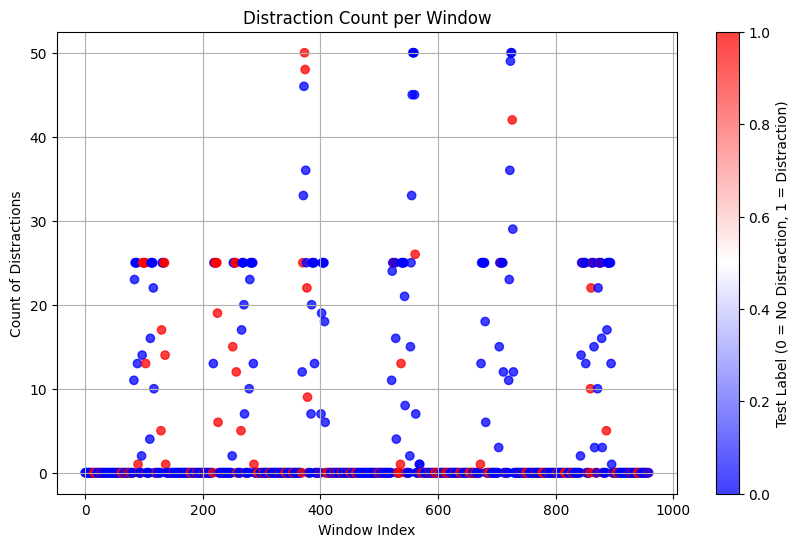

In [34]:
# Plotting
plt.figure(figsize=(10, 6))
plt.grid()

print(error_test_windows_count.shape)
print(len(error_test_windows_count))
print(f"{test_labels.shape}")
# Scatter plot, coloring points based on the label
plt.scatter(range(len(error_test_windows_count)), error_test_windows_count, 
            c=test_labels, cmap='bwr', label='Distraction Count', alpha=0.75)

# Labeling the plot
plt.xlabel('Window Index')
plt.ylabel('Count of Distractions')
plt.title('Distraction Count per Window')
plt.colorbar(label='Test Label (0 = No Distraction, 1 = Distraction)')
plt.show()

## Visualize errors

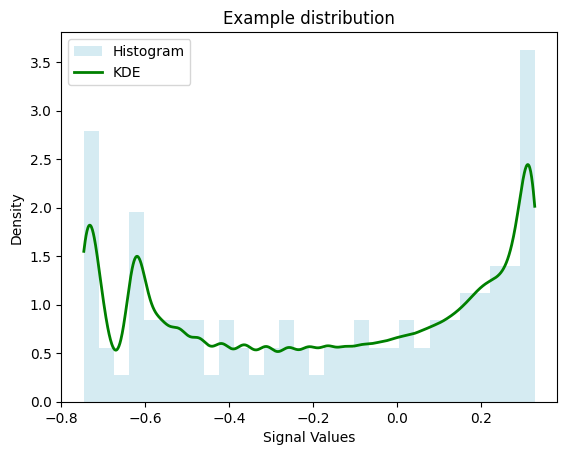

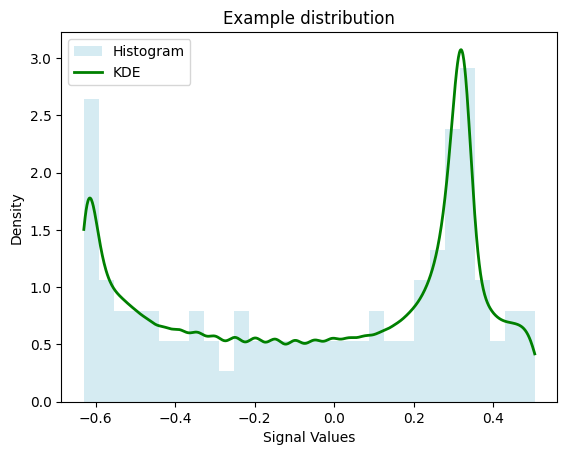

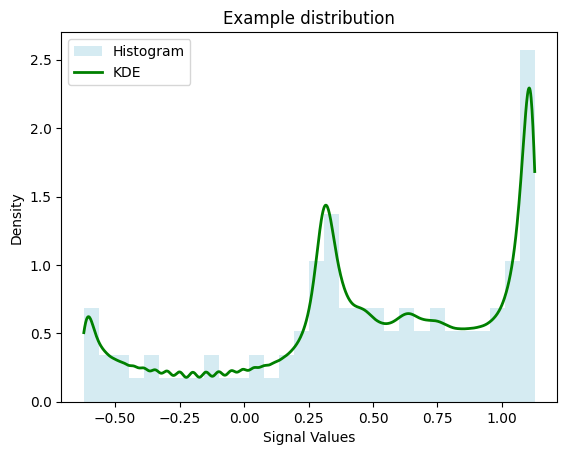

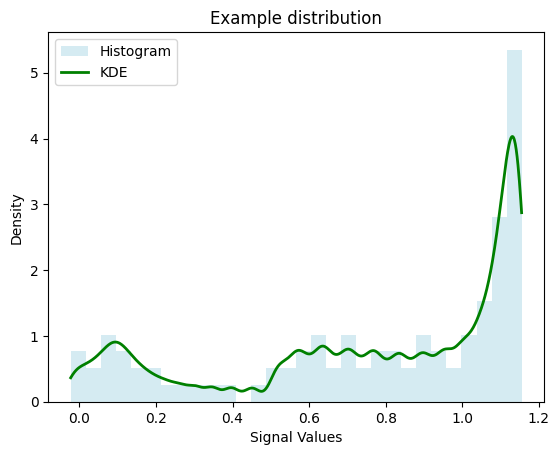

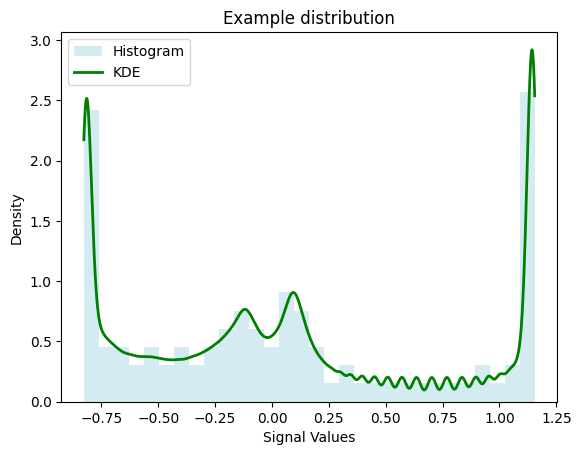

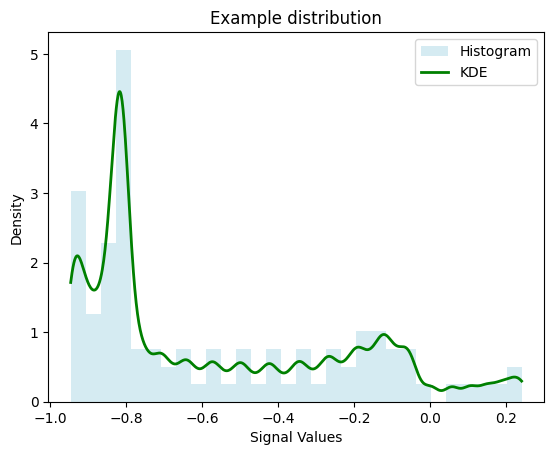

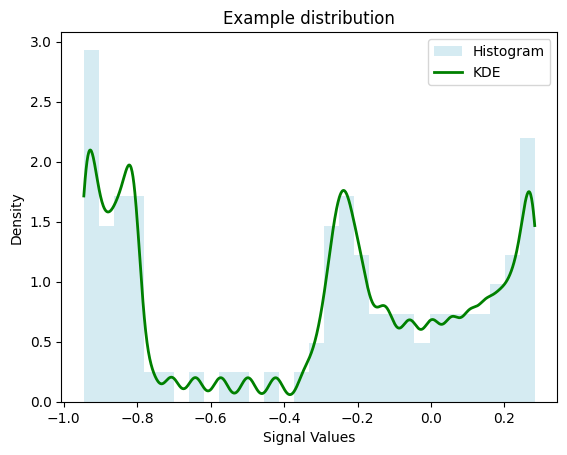

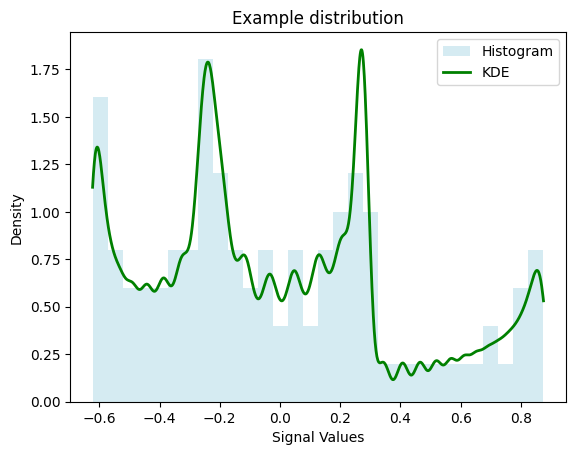

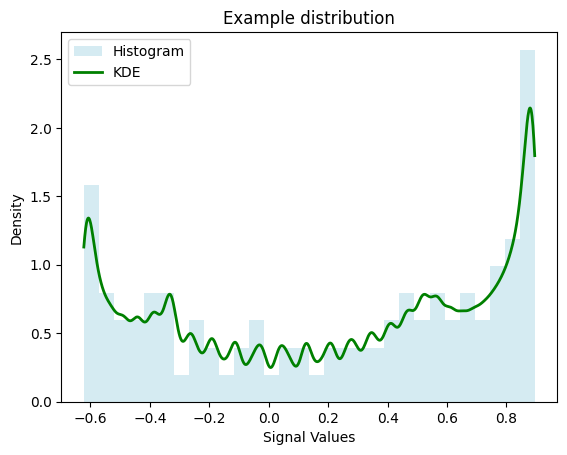

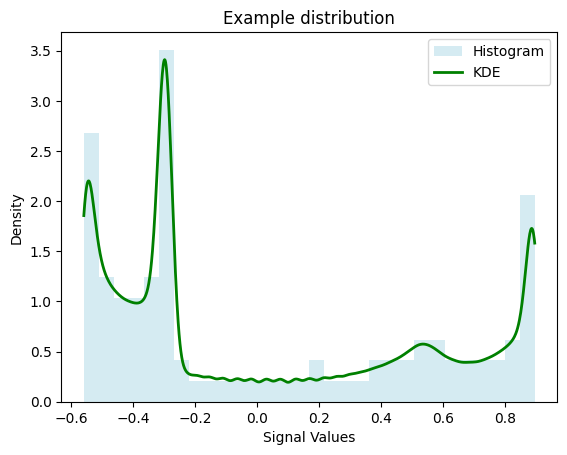

In [35]:
for i in range(10):
    color = 'green'
    if error_test_windows_count[i] > 20:
        color = 'red'
    plot_kde_histogram(u_test_windows[i], title='Example distribution', bandwidth=0.02, kde_color=color)

## Plotting routines

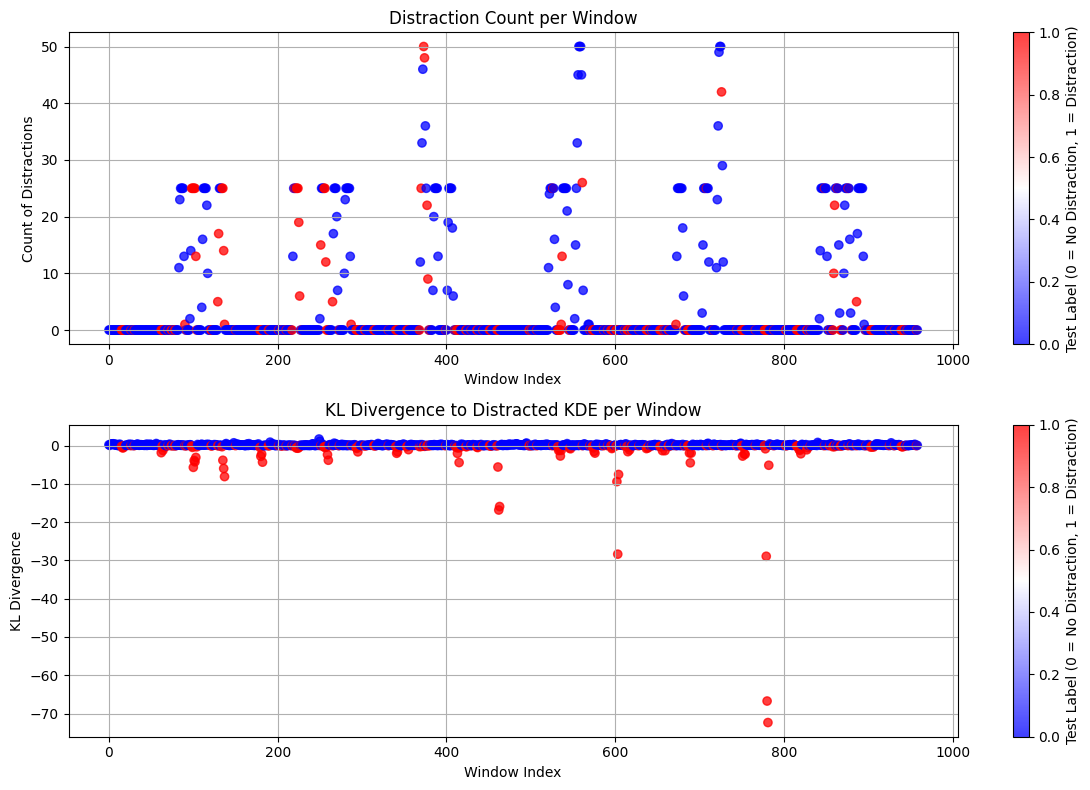

In [36]:
# Plotting the distraction count
plt.figure(figsize=(12, 8))

# First plot: distraction count
plt.subplot(2, 1, 1)
plt.grid()
plt.scatter(range(len(error_test_windows_count)), error_test_windows_count, 
            c=test_labels, cmap='bwr', label='Distraction Count', alpha=0.75)
plt.xlabel('Window Index')
plt.ylabel('Count of Distractions')
plt.title('Distraction Count per Window')
plt.colorbar(label='Test Label (0 = No Distraction, 1 = Distraction)')

# Second plot: KL divergence to distracted KDE
plt.subplot(2, 1, 2)
plt.grid()
plt.scatter(range(len(kl_dists)), np.array(kl_dists) - np.array(kl_not_dists), 
            c=test_labels, cmap='bwr', alpha=0.75, label='Difference KL Divergence between estimated distribution and reference KDE (Distracted - Not Distracted)')
plt.xlabel('Window Index')
plt.ylabel('KL Divergence')
plt.title('KL Divergence to Distracted KDE per Window')
plt.colorbar(label='Test Label (0 = No Distraction, 1 = Distraction)')

# Adjust layout and show both plots
plt.tight_layout()
plt.show()

## Fit Gaussian (as opposed to KDE)

In [37]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.special import kl_div

def fit_gaussian(data):
    """
    Fit a multivariate Gaussian to the data.
    
    Parameters:
    data (array-like): 2D array of shape (n_samples, n_features).
    
    Returns:
    tuple: Mean vector and covariance matrix of the Gaussian.
    """
    mean = np.mean(data, axis=0)
    covariance = np.cov(data, rowvar=False)
    return mean, covariance

def kl_divergence_gaussian(mean1, cov1, mean2, cov2):
    """
    Compute the KL divergence between two multivariate Gaussians.
    
    Parameters:
    mean1, mean2 (array-like): Mean vectors of the Gaussians.
    cov1, cov2 (array-like): Covariance matrices of the Gaussians.
    
    Returns:
    float: KL divergence between the two Gaussian distributions.
    """
    dist1 = multivariate_normal(mean=mean1, cov=cov1)
    dist2 = multivariate_normal(mean=mean2, cov=cov2)
    
    def kl_divergence_single_point(x):
        p_x = dist1.pdf(x)
        q_x = dist2.pdf(x)
        return kl_div(p_x, q_x)
    
    # Grid for evaluation
    grid = np.random.multivariate_normal(mean1, cov1, size=1000)
    kl_divergences = np.array([kl_divergence_single_point(x) for x in grid])
    
    # Average KL divergence
    return np.mean(kl_divergences)

def classify_windows(e_windows, u_windows, mean_distracted, cov_distracted, mean_not_distracted, cov_not_distracted):
    """
    Classify the windows as distracted or not distracted based on KL divergence
    from reference Gaussian distributions (distracted and not distracted distributions).
    
    Parameters:
    e_windows (list of arrays): Test windows of the error signal.
    u_windows (list of arrays): Test windows of the control input signal.
    mean_distracted (array-like): Mean vector for the distracted state.
    cov_distracted (array-like): Covariance matrix for the distracted state.
    mean_not_distracted (array-like): Mean vector for the non-distracted state.
    cov_not_distracted (array-like): Covariance matrix for the non-distracted state.
    
    Returns:
    list: Labels for each window (1 = distracted, 0 = not distracted).
    """
    labels = np.zeros(len(e_windows)) 
    kl_dist_list = []
    kl_not_dist_list = []

    for i in range(len(e_windows)):
        # Stack e and u into a multivariate window of shape (window_size, 2)
        window_data = np.column_stack((e_windows[i], u_windows[i]))  # Combine e and u

        # Fit Gaussian to the current window
        mean_window, cov_window = fit_gaussian(window_data)
        
        # Compute KL divergence between current window and reference Gaussians
        kl_dist = kl_divergence_gaussian(mean_window, cov_window, mean_distracted, cov_distracted)
        kl_not_dist = kl_divergence_gaussian(mean_window, cov_window, mean_not_distracted, cov_not_distracted)
        
        # Classify based on which divergence is smaller
        labels[i] = int(kl_dist < kl_not_dist)

        kl_dist_list.append(kl_dist)
        kl_not_dist_list.append(kl_not_dist)
    
    return labels, kl_dist_list, kl_not_dist_list

# Fit Gaussians for distracted and non-distracted states using the 2D data
mean_distracted, cov_distracted = fit_gaussian(input_distracted)
mean_not_distracted, cov_not_distracted = fit_gaussian(input_not_distracted)

# Classify test windows based on multivariate Gaussian models (both error and control signals)
test_labels, kl_dists, kl_not_dists = classify_windows(error_test_windows, u_test_windows, mean_distracted, cov_distracted, mean_not_distracted, cov_not_distracted)

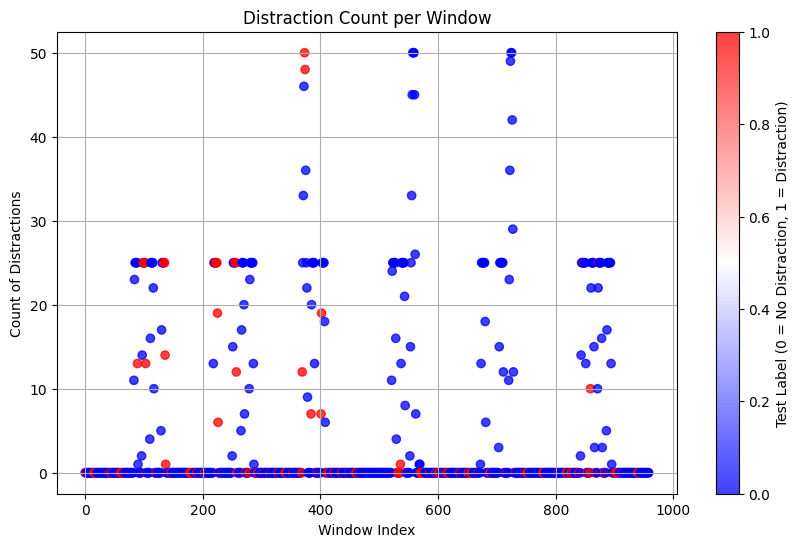

In [38]:
# Plotting
plt.figure(figsize=(10, 6))
plt.grid()
# Scatter plot, coloring points based on the label
plt.scatter(range(len(error_test_windows_count)), error_test_windows_count, 
            c=test_labels, cmap='bwr', label='Distraction Count', alpha=0.75)

# Labeling the plot
plt.xlabel('Window Index')
plt.ylabel('Count of Distractions')
plt.title('Distraction Count per Window')
plt.colorbar(label='Test Label (0 = No Distraction, 1 = Distraction)')
plt.show()

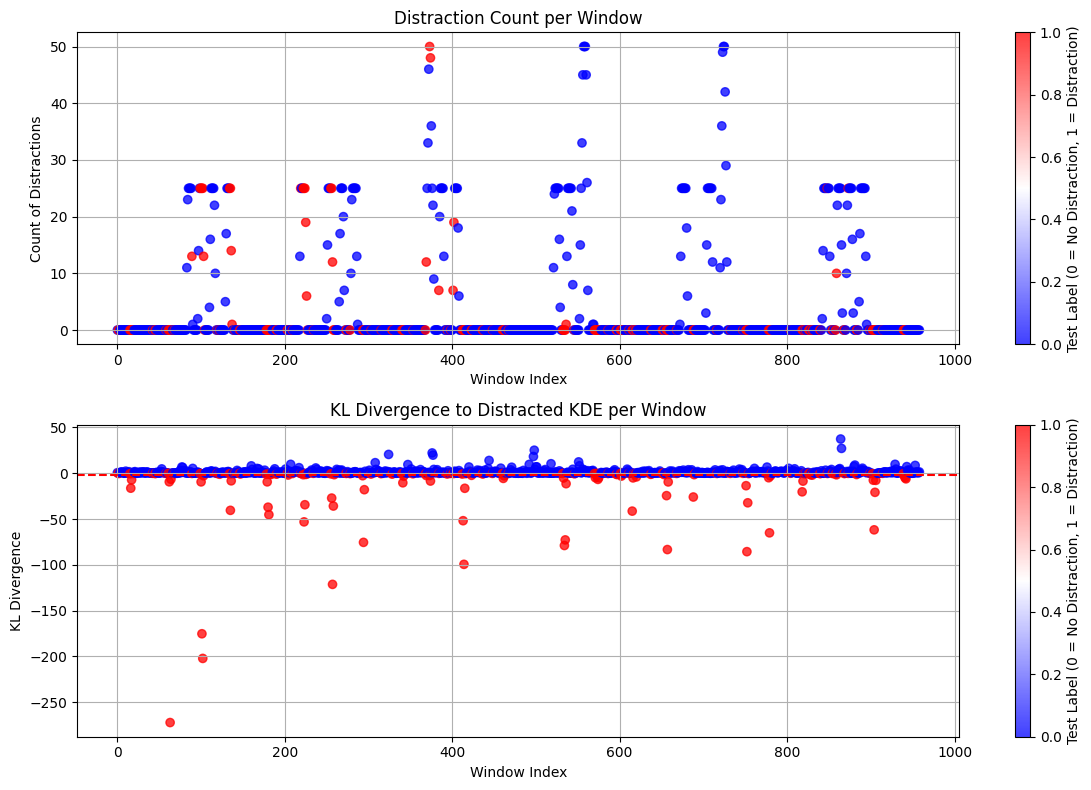

In [39]:
# Plotting the distraction count
plt.figure(figsize=(12, 8))

# First plot: distraction count
plt.subplot(2, 1, 1)
plt.grid()
plt.scatter(range(len(error_test_windows_count)), error_test_windows_count, 
            c=test_labels, cmap='bwr', label='Distraction Count', alpha=0.75)
plt.xlabel('Window Index')
plt.ylabel('Count of Distractions')
plt.title('Distraction Count per Window')
plt.colorbar(label='Test Label (0 = No Distraction, 1 = Distraction)')

# Second plot: KL divergence to distracted KDE
plt.subplot(2, 1, 2)
plt.grid()
plt.scatter(range(len(kl_dists)), np.array(kl_dists) - np.array(kl_not_dists), 
            c=test_labels, cmap='bwr', alpha=0.75, label='KL Divergence to Distracted')
plt.xlabel('Window Index')
plt.ylabel('KL Divergence')
plt.title('KL Divergence to Distracted KDE per Window')
plt.colorbar(label='Test Label (0 = No Distraction, 1 = Distraction)')

# draw an horizontal line at y=-2
plt.axhline(y=-2, color='r', linestyle='--')

# Adjust layout and show both plots
plt.tight_layout()
plt.show()